# Static simulation of the glcuose/xylose triculture

## Set-up for all simulations:

In [1]:
from reframed import Community, Environment
from reframed import load_cbmodel, FBA, plot_flux_envelope

# load all models
CAL2 = load_cbmodel("../GEMs/CAL2.xml", flavor="bigg")
SAL9 = load_cbmodel("../GEMs/SAL9.xml", flavor="bigg")
MAM2 = load_cbmodel("../GEMs/MAM2.xml", flavor="bigg")
MRA = load_cbmodel("../GEMs/MRA.xml", flavor="bigg")

The strains in this experiment are practically identical to the previous tri-culture, except for the disabling of glucose / xylose utilisation pathways. To simplify, instead of knocking out the many genes, I am just restricing glucose and xylose import from the external environmemt to the periplasm:

In [2]:
# knock out glucose and xylose in k12 and bl21 -derived strains respectivly by removing their uptake reactions (from external metabolite to periplasm)

CAL11 = CAL2.copy()
CAL11.set_flux_bounds('R_GLCtex_copy1', 0, 0)
CAL11.set_flux_bounds('R_GLCtex_copy2', 0, 0)
CAL11.id = "CAL11"

MAM3 = MAM2.copy()
MAM3.set_flux_bounds('R_GLCtex_copy1', 0, 0)
MAM3.set_flux_bounds('R_GLCtex_copy2', 0, 0)
MAM3.id = "MAM3"

SAL11 = SAL9.copy()
SAL11.set_flux_bounds('R_XYLtex', 0, 0)
SAL11.id = "SAL11"

In [3]:
# in order to equal the playing field between BL21 and K12 derived models:

# adjust the biomass reaction
SAL11.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_atp_c"] = -75.55223
SAL11.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_h_c"] = 75.377230
SAL11.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_adp_c"] = 75.377230
SAL11.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_pi_c"] = 75.373230
SAL11.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_h2o_c"] = -70.028756

# adjust the ATP maintanance requrenment
SAL11.reactions.R_ATPM.lb = 6.86

In [10]:
# impose constraints on SAL9 reactions so that the model cannot go crazy with the loop

SAL11.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
SAL11.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
SAL11.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
SAL11.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

# likewise on the MRA model
MRA.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
MRA.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
MRA.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
MRA.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

In [11]:
# build community object
community = Community('RA_community', [CAL11, SAL11, MAM3])
merged_community = community.merge_models()

# get medium
medium = Environment.from_model(CAL2).apply(merged_community, exclusive=True, inplace=False)
# add xylose to the medium
medium["R_EX_xyl__D_e"] = (-8, float("inf"))

## Community growth
some checks, monitoring pathways, crossfeeding, whether there can still be growth on glucose ect...

In [80]:
# steadycom
from reframed import SteadyCom

sc_sol = SteadyCom(community, constraints=medium)
print(sc_sol)

Community growth: 1.5537109375000002
CAL11	0.009784643066697213
SAL11	0.9822510439312109
MAM3	0.007964313002091885


In [81]:
exchanges = sc_sol.compute_exchanges()

In [85]:
print("SAL11 xylose uptake:", exchanges[('SAL11', 'M_glc__D_e')])
print("CAL11 glucose uptake:", exchanges[('CAL11', 'M_xyl__D_e')])
print("MAM3 glucose uptake:", exchanges[('MAM3', 'M_xyl__D_e')])

SAL11 xylose uptake: -10.0
CAL11 glucose uptake: -0.9643845565883696
MAM3 glucose uptake: -7.03561544341163


In [86]:
sc_sol.cross_feeding(as_df=True).dropna().sort_values("rate", ascending = False)

,donor,receiver,compound,rate
5,CAL11,SAL11,M_idon__L_e,9.784643
59,SAL11,CAL11,M_glyald_e,9.784643
57,CAL11,SAL11,M_glyc_e,9.784643
105,SAL11,CAL11,M_glcn_e,9.784643
53,SAL11,CAL11,M_lac__D_e,9.784643
...,...,...,...,...
35,MAM3,SAL11,M_ala__D_e,0.000172
40,SAL11,CAL11,M_4abzglu_e,0.000010
71,CAL11,MAM3,M_dxylnt_e,0.000010
98,CAL11,SAL11,M_succ_e,0.000009


In [87]:
cal11_dict = dict()
sal11_dict = dict()
mam3_dict = dict()

for reaction in sc_sol.values.keys():
    if reaction[-5:] == "CAL11":
        cal11_dict[reaction[2:-6]] = sc_sol.values[reaction]
    elif reaction[-5:] == "SAL11":
        sal11_dict[reaction[2:-6]] = sc_sol.values[reaction]
    elif reaction[-4:] == "MAM3":
        mam3_dict[reaction[2:-5]] = sc_sol.values[reaction]

In [91]:
from escher import Builder

cal11_flux_map = Builder(map_name='iJO1366.Central metabolism',)
cal11_flux_map.reaction_data = cal11_dict
cal11_flux_map

Builder(reaction_data={'': 0.009784643066697215, 'CYTDK2': 0.002440382428511697, 'XPPT': 0.0, 'HXPRT': 0.0, 'N…

### for equal ATP requirements:

In [122]:
# steadycom
from reframed import SteadyCom

sc_sol = SteadyCom(community, constraints=medium)
print(sc_sol)

Community growth: 1.515625
CAL11	0.1550362386281504
SAL11	0.46001877786577516
MAM3	0.38494498350607437


In [123]:
print("SAL11 xylose uptake:", exchanges[('SAL11', 'M_glc__D_e')])
print("CAL11 glucose uptake:", exchanges[('CAL11', 'M_xyl__D_e')])
print("MAM3 glucose uptake:", exchanges[('MAM3', 'M_xyl__D_e')])

SAL11 xylose uptake: -10.0
CAL11 glucose uptake: -0.9643845565883696
MAM3 glucose uptake: -7.03561544341163


- adjusting the ATP requirements of the BL21 -derived strain leads to more equal growth between the strains, but overall same community growth rate

## Max theoretical RA production

### standard FBA

In [92]:
FBA_sol = FBA(merged_community, constraints=medium, objective='R_EX_rosma_e')
print(FBA_sol)
FBA_sol.show_values(pattern="R_EX", sort="True")

Objective: 4.276659292035399
Status: Optimal

R_EX_o2_e    -14.4668
R_EX_glc__D_e -10
R_EX_xyl__D_e -8
R_EX_rosma_e  4.27666
R_EX_h_e      8.55332
R_EX_co2_e    23.0201
R_EX_h2o_e    61.5101


- on the whole, model is utilising max of both xylose and glucose, and is therefore able to produce more RA than the triculture that is growing only on glucose

<AxesSubplot: xlabel='Community growth rate', ylabel='R_EX_rosma_e'>

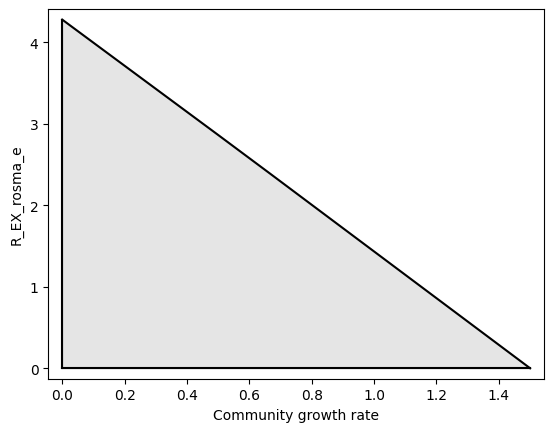

In [93]:
from reframed import plot_flux_envelope

plot_flux_envelope(merged_community, merged_community.biomass_reaction, 'R_EX_rosma_e', constraints=medium)

### SteadyCom

In [94]:
import updated_steadycom

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", sc_com_som.values["R_EX_rosma_e"])

RA production rate:  0.001291952662941555


### for equal ATP requirements:

In [126]:
import updated_steadycom

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", sc_com_som.values["R_EX_rosma_e"])

RA production rate:  0.0018289804228080603


- gives higher relative RA production

## Relative species abundance

experimental data:

         time  subpopulation_percentage strain
8   60.016004                  0.171697  CAL11
17  60.016004                  0.715428  SAL11
26  60.016004                  0.107159   MAM3


<AxesSubplot: xlabel='time', ylabel='subpopulation_percentage'>

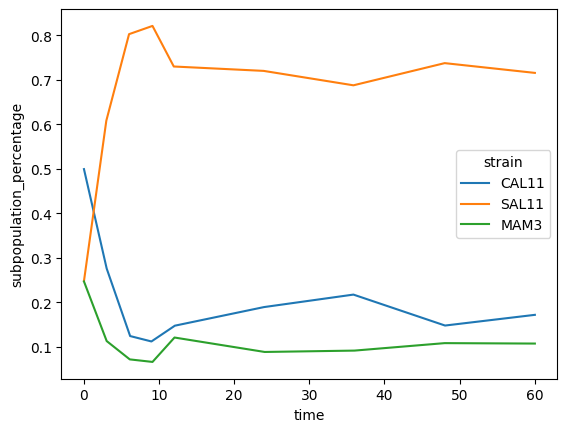

In [97]:
import pandas as pd
import seaborn as sns

relative_percentage = pd.read_csv("exp_data/subpop_data_xyl_glc.csv")

end_time = relative_percentage.time.max().round(0)
end_vals = relative_percentage[relative_percentage["time"].round(0) == end_time]
print(end_vals)

sns.lineplot(relative_percentage, x="time", y="subpopulation_percentage", hue="strain", hue_order=["CAL11", "SAL11", "MAM3"])

  0%|          | 0/11 [00:00<?, ?it/s]

Text(0.5, 0, 'fraction of optimal solution')

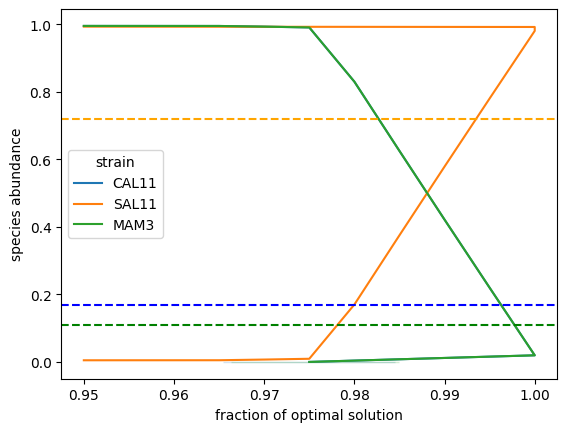

In [95]:
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_list = []

#for i in tqdm(range(950, 1001, 1)):
for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadyComVA(community, constraints=medium, obj_frac=frac)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list)
results_df.set_index("frac")

plot_df = results_df.explode(["CAL11", "SAL11", "MAM3"])
df_melt = plot_df.melt('frac', var_name='strain', value_name='species abundance')

sns.lineplot(data=df_melt, x="frac", y="species abundance", hue="strain",orient="y")

#stipled lines with exp. steady-state species abundance
plt.axhline(y=0.17, linestyle='--', color='blue')
plt.axhline(y=0.72, linestyle='--', color='orange')
plt.axhline(y=0.11, linestyle='--', color='green')

plt.xlabel("fraction of optimal solution")

In [100]:
results_df.iloc[8]

CAL11                  [0.0, 0.42142660194638193]
SAL11    [0.5785733980509811, 0.9922047109074257]
MAM3                    [0.0, 0.4214266019509992]
frac                                         0.99
Name: 8, dtype: object

- results can be replicated a 99% of optimum - a little before solution deteriorates

### for equal ATP requirements:

  0%|          | 0/11 [00:00<?, ?it/s]

Text(0.5, 0, 'fraction of optimal solution')

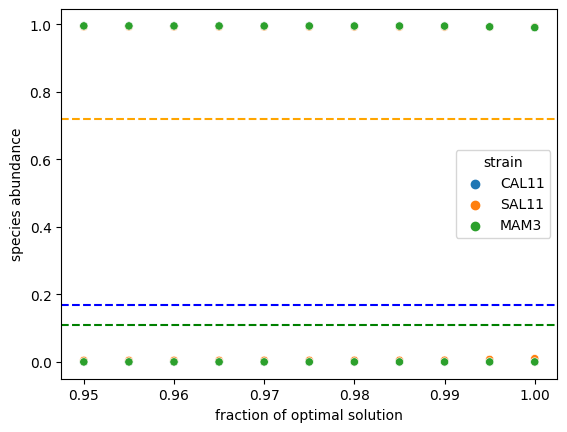

In [44]:
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_list = []

#for i in tqdm(range(950, 1001, 1)):
for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadyComVA(community, constraints=medium, obj_frac=frac)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list)
results_df.set_index("frac")

plot_df = results_df.explode(["CAL11", "SAL11", "MAM3"])
df_melt = plot_df.melt('frac', var_name='strain', value_name='species abundance')

sns.scatterplot(data=df_melt, x="frac", y="species abundance", hue="strain")

#stipled lines with exp. steady-state species abundance
plt.axhline(y=0.17, linestyle='--', color='blue')
plt.axhline(y=0.72, linestyle='--', color='orange')
plt.axhline(y=0.11, linestyle='--', color='green')

plt.xlabel("fraction of optimal solution")

- inconclusive / way to wide solution space

## Relative species abundance for different levels of RA production

In [114]:
import updated_steadycom
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

num_points = 11

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
max_RA = sc_com_som.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0.001163, num=num_points) #hard-coded for 90%

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadyComVA(community, constraints=all_constraints, obj_frac=0.99)

    com_fva_solution["RA_prod_rate"] = RA_level
    #com_fva_solution["RA_percentage"] = 100 - i*(num_points-1)
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list)
results_df["RA_percentage"] = np.linspace(100, 90, num_points)

  0%|          | 0/11 [00:00<?, ?it/s]

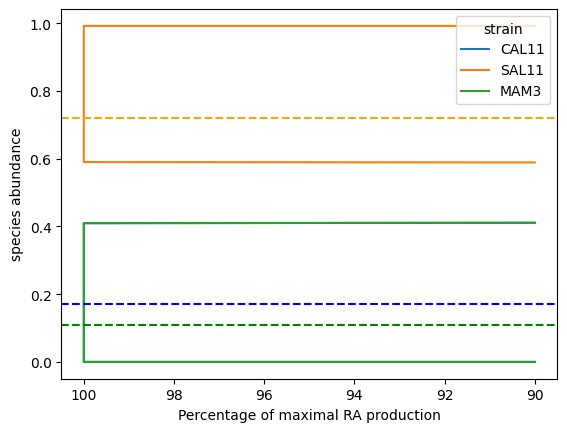

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = results_df.explode(["CAL11", "SAL11", "MAM3"])
df_melt = plot_df.drop(columns=["RA_prod_rate"]).melt('RA_percentage', var_name='strain', value_name='species abundance')

#sns.lineplot(data=df_melt, x="RA_prod_rate", y="species abundance", hue="strain",orient="y")
sns.lineplot(data=df_melt, x="RA_percentage", y="species abundance", hue="strain",orient="y")

#stipled lines with exp. steady-state species abundance
plt.axhline(y=0.17, linestyle='--', color='blue')
plt.axhline(y=0.72, linestyle='--', color='orange')
plt.axhline(y=0.11, linestyle='--', color='green')

plt.xlabel("Percentage of maximal RA production")

plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()

### for equal ATP requirements:

In [50]:
import updated_steadycom
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

num_points = 11

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
max_RA = sc_com_som.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0.001463, num=num_points) #hard-coded for 80%

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadyComVA(community, constraints=all_constraints, obj_frac=1)

    com_fva_solution["RA_prod_rate"] = RA_level
    #com_fva_solution["RA_percentage"] = 100 - i*(num_points-1)
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list)
results_df["RA_percentage"] = np.linspace(100, 80, num_points)

  0%|          | 0/11 [00:00<?, ?it/s]

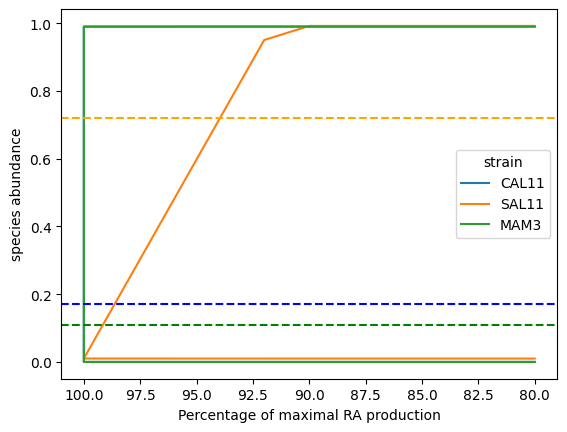

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = results_df.explode(["CAL11", "SAL11", "MAM3"])
df_melt = plot_df.drop(columns=["RA_prod_rate"]).melt('RA_percentage', var_name='strain', value_name='species abundance')

#sns.lineplot(data=df_melt, x="RA_prod_rate", y="species abundance", hue="strain",orient="y")
sns.lineplot(data=df_melt, x="RA_percentage", y="species abundance", hue="strain",orient="y")

#stipled lines with exp. steady-state species abundance
plt.axhline(y=0.17, linestyle='--', color='blue')
plt.axhline(y=0.72, linestyle='--', color='orange')
plt.axhline(y=0.11, linestyle='--', color='green')

plt.xlabel("Percentage of maximal RA production")

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

- the added constraint of RA-production makes the solution-space slightly less wide
- the exp. results are feasible at about a 93% of max RA production